<a href="https://colab.research.google.com/github/dnhshl/cc-ai/blob/main/Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frozen Lake - Einfaches Q-Learning Beispiel

Wir verwenden eine von openAI zur Verfügung gestellte Simulationsumgebung für Reinforcement Probleme (https://gym.openai.com/).

In [1]:
import gym

### FrozenLake (a Grid World)

Wir nutzen ein einfaches Beispiel: FrozenLake.
Problembeschreibung von OpenAI:

> *Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.*


<img src="https://zitaoshen.rbind.io/project/rl/1-min-of-reinforcement-learning-q-learning/featured.png?raw=1" alt="FrozenLake" style="width: 400px;"/>

Wir starten in der linken oberen Ecke (S). Unser Ziel ist es, zur unteren rechten Ecke (G) zu gelangen, ohne zwischendurch in ein Loch (H) zu fallen.

Es gibt vier mögliche Aktionen:

0=links, 1=runter, 2=rechts, 3=rauf

Die Stati sind die 16 Felder (0 .. 15).


Jede Bewegung führt dazu, dass sich der Status des Agenten von $s_t$ zu $s_{t+1}$ ändert, wenn er seinen Standort ändert, es sei denn, er versucht, sich in Richtung einer Wand zu bewegen, was dazu führt, dass sich der Status des Agenten nicht ändert (der Agent bewegt sich nicht).
Für das Erreichen des Ziels (G) erhalten wir eine positive Belohnung von „+1“, die je nach Dauer abgezinst wird.
Obwohl es keine negative Belohnung für das Fallen in ein Loch gibt (H), zahlt der Agent dennoch eine Strafe in dem Sinne, dass das Fallen in das Loch die Episode beendet und ihn daher daran hindert, eine Belohnung zu erhalten.
Wir wollen eine Richtlinie $\pi$ lernen, die uns in möglichst wenigen Schritten von unserem Startort (S) zum Ziel (G) führt.

Das Problem ist schwieriger, als es sich für uns in der ersten Betrachtung darstellt:

- **Kenntnis der Zustände und Übergangswahrscheinlichkeiten:** Aus der globalen Sicht von oben könnte der erste Gedanke sein, einen Weg vom Start bis zum Ziel zu planen, genau wie bei einem Labyrinth.
Diese Ansicht wird uns jedoch den Algorithmus-Designern zur Verfügung gestellt, damit wir das vorliegende Problem visualisieren können.
Der Agent, der die Aufgabe lernt, erhält dieses Vorwissen *nicht*; Alles was wir sagen werden ist, dass es 16 Stati und 4 mögliche Aktionen in jedem Status gibt.
Eine passendere Analogie wäre:  Sie stehen mit verbundenen Augen auf einem zugeforenen See. Jedes mal, wenn Sie sich entscheiden, einen Schritt in eine von vier Richtungen zu machen, wird Ihnen Ihr neuer Zustand (Standort) mitgeteilt. Finden Sie das Frisbee, ohne ins Eis einzubrechen, erhalten Sie eine Belohnung, die umso größer ist, je schneller Sie das Frisbee finden.

- **Kenntnis des Ziels (Belohnung):** 
Der Agent weiß  *nicht*, was das Ziel ist. 
Vielmehr lernen Sie das Ziel, indem es Belohnungen (oder Strafen) gibt, und der Algorithmus aktualisiert seine Richtlinie zur Wahl von Aktionen so, dass er Aktionen mit größerer Wahrscheinlichkeit erneut durchführt, die voraussichtlich zu einer späteren Belohnung führen. 
Beachten Sie, dass dies bedeutet, dass ein Agent, wenn er bestimmte Belohnungen nie erhält, nicht weiß, dass sie existieren.

- **Vorkenntnisse in Pfadfindung, Physik, etc.:** Als Mensch bringen Sie, auch wenn Sie diese Aufgabe noch nicht gelöst haben, enorme Vorkenntnisse zu diesem Problem mit.
Sie wissen beispielsweise, dass der kürzeste Weg zu einem Ziel eine Linie ist.
Sie wissen, dass Norden, Süden, Osten und Westen Richtungen sind und dass Sie nach Norden und dann nach Süden zurückkehren, wo Sie bereits waren.
Sie wissen, dass Eis rutschig ist.
Sie wissen, dass eisiges Wasser kalt ist.
Sie wissen, dass es schlecht ist, in eiskaltem Wasser zu sein.
Der Agent weiß von all diesen Dingen nichts; seine anfängliche Richtlinie besteht im Wesentlichen darin, Aktionen vollständig zufällig auszuwählen.
Am Ende des Trainings wird es immer noch nicht wissen, was abstrakte Konzepte wie "Nord/Süd", "kalt" oder "rutschig" bedeuten, aber es wird (hoffentlich) eine gute Politik gelernt haben, die es ihm ermöglicht, das Ziel zu erreichen.


In [30]:
env = gym.make('FrozenLake-v0')
print(env.observation_space, env.action_space)

Discrete(16) Discrete(4)


Über einen `reset() `kann das Environment jeweils "auf Start" zurückgesetzt werden. Der Status $s$ wird dann also 0 (das erste Feld) sein.


In [32]:
s = env.reset()
print(s)

0


Mittels `render()` kann der aktuelle Status dargestellt werden.


In [33]:
env.render()


SFFF
FHFH
FFFH
HFFG


Die Standard FrozenLake-Umgebung ist "rutschig". Wegen des Eises haben Sie, wenn Sie versuchen, in eine Richtung zu gehen, eine 1/3-Chance, in die von Ihnen gemeinte Richtung und die beiden angrenzenden Richtungen zu gehen. Wenn wir zum Beispiel versuchen, nach rechts zu gehen, haben wir die gleiche Wahrscheinlichkeit, stattdessen abzurutschen und nach oben und unten zu gehen. Dies macht die Sache etwas komplizierter.

Wir definieren uns zunächst eine "nicht rutschige" Umgebung, in der die Aktion deterministisch ausgeführt wird.


In [38]:
# Non-slippery version

from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)
env = gym.make('FrozenLakeNotSlippery-v0')
env.reset()

Error: ignored

Mittels `step(action)` führen wir einen Schritt durch.
`step(2)` entspricht also einer Bewegung nach rechts.
Beachten Sie, dass die Ausgabe ein Tupel von vier Elementen ist: der nächste Statusg (`object`), der reward (`float`), ob die Episode fertig ist (`boolean`) und weitere Infos (`dict` ), die für das Debuggen nützlich sein können.

In [44]:
env.reset()
env.render()
env.step(2)
env.render()


SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


Next, let's `render()` to visualize what happened.
Observe that this particular environment prints out the action we took in parentheses up top, in this case "(Right)", and then shows the result of that action.
Notice that while most of the time, we succeed in going in the direction we want to, occasionally we slip on the ice and go in a direction we didn't intend.

In [9]:
env.render()

  (Right)
SFFF
FHFH
FFFH
HFFG


We can keep doing this as many times as we want.
Since we're in Jupyter, we can just keep running the same cell (making small edits to change our action).

Notice that once we fall into a hole, the episode is over, and we can no longer do anything.
The same is true after reaching the goal.

In [10]:
env.step(0)
env.render()

  (Left)
SFFF
FHFH
FFFH
HFFG


Before we get into any RL, let's see how random actions perform in this environment:

In [11]:
env.reset()
done = False

while not done:
    env.render()
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)


SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG


Hm. 
Not great. 
Alright, so clearly picking random steps isn't very likely to take us to the goal.
It's apparent just from looking at the map that there're much better policies that we can learn.
How are we going to do so?

#### Q-learning
There are many algorithms that we can use, but let's choose Q-learning, which we covered earlier today.
Remember, in Q-learning (and SARSA, it turns out), we're trying learn the Q values for the states in our system.

The Q value for a policy $\pi$ is a function of the state $s$ and action $a$ and is defined as the following:
\begin{equation}
Q_\pi (s,a) = \mathbb{E}\big[\sum_{t=0}^{\infty} \gamma^t r_t \big|\pi, s_0 = s, a_0 = a\big]
\end{equation}
Intuitively, the Q value is the total reward (including discounting) that the agent will gain if it takes action $a$ from state $s$ and then follows policy $\pi$ for the rest of the episode.
As one might expect, if Q is known exactly, the agent will attain the highest reward from $s$ if the policy $\pi$ is to pick the $a$ with the highest Q value.

Okay, so if we know the Q values for the system, then we can trivially find the optimal policy.
So what are the Q values of the system?
Well, at the beginning, we don't know, but we can try to learn them through experience.
This is where Q-learning comes in.
Q-learning iteratively updates the Q values in the following way:
\begin{equation}
Q_\pi (s_t, a_t) \leftarrow (1 - \alpha) \cdot Q_\pi(s_t, a_t) + \alpha \cdot \big(r_t + \gamma \max_a Q_\pi(s_{t+1}, a)\big)
\end{equation}
Notice that Q-learning is an *off-policy* method, in the sense that you don't actually learn from the trajectory you actually took (otherwise it'd be SARSA).
Instead, we learn from the *greedy* transition, i.e. the best action we know how to take.

And that's it! 
We run our agent through many episodes, experiencing many $s_t \rightarrow a_t \rightarrow s_{t+1}$ transitions and rewards, and just like that, we eventually learn a good Q function (and thus a good policy).
Now of course, there are a bunch of small details and tweaks to make this work in practice, but we'll get to those later.

#### Q-learning in FrozenLake
FrozenLake is a very simple setting, one that we would call a toy problem.
With only 16 states and 4 actions, there are only 64 state-action pairs possible (16x4=64), less if we account for the goal and the holes being episode ending (for simplicity though, we won't). 
With this few state-action pairs, we can actually solve this problem tabularly.
Let's set up a Q table, and initialize the Q-values for all state-action pairs to zeros.
Note that while we could, we're actually not going to need PyTorch in this example; PyTorch's autograd and neural network libraries are unnecessary here, as we're only going to be modifying a table of numbers.
Instead, we'll use a Numpy array to store the Q table.

In [12]:
import numpy as np

#Initialize table with all zeros to be uniform
Q = np.zeros([env.observation_space.n, env.action_space.n])

A few hyperparameters we're going to set:
- `alpha`: learning rate for the Q function
- `gamma`: discount rate for future rewards
- `num_episodes`: number of episodes (trajectories from start to goal/hole) our agent will learn from

We're also going to store our rewards in an array called `rs`.

In [13]:
# Learning parameters
alpha = 0.1
gamma = 0.95
num_episodes = 2000

# array of reward for each episode
rs = np.zeros([num_episodes])

Now for the bulk of algorithm itself.
Notice that we're going to loop through the process `num_episodes` times, resetting the environment each time.
At each step, we take the action with the highest Q value for our current state, with some randomness added in (especially at the beginning) to encourage exploration.
After each action, we update our Q table greedily based on the reward experienced and the next best action.
We also make sure to update our state, rinse, and repeat. 
We continue taking actions in an episode until it is `done`, storing the final total reward for the episode.

In [14]:
for i in range(num_episodes):
    # Set total reward and time to zero, done to False
    r_sum_i = 0
    t = 0
    done = False
    
    #Reset environment and get first new observation
    s = env.reset()
    
    while not done:
        # Choose an action by greedily (with noise) from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(i/10+1)))
        
        # Get new state and reward from environment
        s1, r, done, _ = env.step(a)
        
        # Update Q-Table with new knowledge
        Q[s,a] = (1 - alpha)*Q[s,a] + alpha*(r + gamma*np.max(Q[s1,:]))
        
        # Add reward to episode total
        r_sum_i += r*gamma**t
        
        # Update state and time
        s = s1
        t += 1
    rs[i] = r_sum_i

How did we do?
Let's take a look at the rewards that we saved.
We can plot the reward versus the episode number, and hopefully we'll see some sort of an increase over time.
RL performance can be extremely noisy, so let's instead plot a moving average.

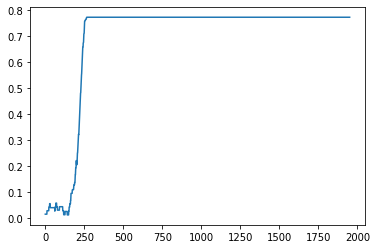

In [15]:
## Plot reward vs episodes
import matplotlib.pyplot as plt

# Sliding window average
r_cumsum = np.cumsum(np.insert(rs, 0, 0)) 
r_cumsum = (r_cumsum[50:] - r_cumsum[:-50]) / 50

# Plot
plt.plot(r_cumsum)
plt.show()

Pretty good.
We might also be interested in how often our agent actually reached the goal.
This won't account for how quickly the agent got there (which might also of interest), but let's ignore that for now.
To prevent us from being overwhelmed by data points, let's bucket the values into 10 stages, printing out how many episodes of each stage resulted in finding the goal.

In [16]:
# Print number of times the goal was reached
N = len(rs)//10
num_Gs = np.zeros(10)

for i in range(10):
    num_Gs[i] = np.sum(rs[i*N:(i+1)*N] > 0)
    
print("Rewards: {0}".format(num_Gs))

Rewards: [  9. 164. 200. 200. 200. 200. 200. 200. 200. 200.]


Our RL agent does a really good job at navigating the FrozenLake when its moves are deterministic, but after all, this is
supposed to be *Frozen*Lake, so where's the fun without the slipperiness?
Let's go back to the original environment and see how the agent does.

0


In [23]:
def perform_and_render():
  
  s = env.reset()
  done = False

  while not done:
    print(env.nS)
    env.render()
    action = np.argmax(Q[s,:]) 
    print(action)
    s, _, done, _ = env.step(action)
  env.render()

In [24]:
perform_and_render()


0

SFFF
FHFH
FFFH
HFFG
1
0
  (Down)
SFFF
FHFH
FFFH
HFFG
1
0
  (Down)
SFFF
FHFH
FFFH
HFFG
2
0
  (Right)
SFFF
FHFH
FFFH
HFFG
2
0
  (Right)
SFFF
FHFH
FFFH
HFFG
1
0
  (Down)
SFFF
FHFH
FFFH
HFFG
2
  (Right)
SFFF
FHFH
FFFH
HFFG


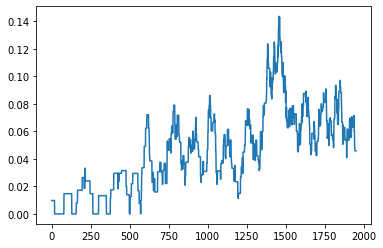

Rewards: [ 2.  5.  9. 16. 22. 24. 26. 51. 40. 28.]


In [26]:
env = gym.make('FrozenLake-v0')

#Initialize table with all zeros to be uniform
Q = np.zeros([env.observation_space.n, env.action_space.n])

# Learning parameters
alpha = 0.1
gamma = 0.95
num_episodes = 2000

# array of reward for each episode
rs = np.zeros([num_episodes])

for i in range(num_episodes):
    # Set total reward and time to zero, done to False
    r_sum_i = 0
    t = 0
    done = False
    
    #Reset environment and get first new observation
    s = env.reset()
    
    while not done:
        # Choose an action by greedily (with noise) from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(i/10+1)))
        
        # Get new state and reward from environment
        s1, r, done, _ = env.step(a)
        
        # Update Q-Table with new knowledge
        Q[s,a] = (1 - alpha)*Q[s,a] + alpha*(r + gamma*np.max(Q[s1,:]))
        
        # Add reward to episode total
        r_sum_i += r*gamma**t
        
        # Update state and time
        s = s1
        t += 1
    rs[i] = r_sum_i

## Plot reward vs episodes
# Sliding window average
r_cumsum = np.cumsum(np.insert(rs, 0, 0)) 
r_cumsum = (r_cumsum[50:] - r_cumsum[:-50]) / 50

# Plot
plt.plot(r_cumsum)
plt.show()

# Print number of times the goal was reached
N = len(rs)//10
num_Gs = np.zeros(10)

for i in range(10):
    num_Gs[i] = np.sum(rs[i*N:(i+1)*N] > 0)
    
print("Rewards: {0}".format(num_Gs))

In [28]:
perform_and_render()

16

SFFF
FHFH
FFFH
HFFG
0
16
  (Left)
SFFF
FHFH
FFFH
HFFG
0
16
  (Left)
SFFF
FHFH
FFFH
HFFG
3
16
  (Up)
SFFF
FHFH
FFFH
HFFG
3
16
  (Up)
SFFF
FHFH
FFFH
HFFG
0
16
  (Left)
SFFF
FHFH
FFFH
HFFG
0
16
  (Left)
SFFF
FHFH
FFFH
HFFG
0
16
  (Left)
SFFF
FHFH
FFFH
HFFG
0
16
  (Left)
SFFF
FHFH
FFFH
HFFG
3
16
  (Up)
SFFF
FHFH
FFFH
HFFG
0
16
  (Left)
SFFF
FHFH
FFFH
HFFG
3
16
  (Up)
SFFF
FHFH
FFFH
HFFG
3
16
  (Up)
SFFF
FHFH
FFFH
HFFG
3
16
  (Up)
SFFF
FHFH
FFFH
HFFG
3
16
  (Up)
SFFF
FHFH
FFFH
HFFG
0
16
  (Left)
SFFF
FHFH
FFFH
HFFG
3
16
  (Up)
SFFF
FHFH
FFFH
HFFG
2
  (Right)
SFFF
FHFH
FFFH
HFFG


Much harder.
However, we can see that the model does eventually learn something.

### PyTorch in RL
Hey, not bad.
However, while the previous example was fun and simple, it was noticeably lacking any hint of PyTorch.

We could have used a PyTorch `Tensor` to store the Q table, but that's not any better than using a NumPy array.
PyTorch's true utility comes from building neural networks and calculating/applying gradients automatically, which learning the Q table didn't need. 

#### Continuous domains
In our previous example, we mentioned that with only 16 discrete states and 4 actions/state, the Q table only needed to hold 64 values, which is very manageable.
However, what if the state or action space is continuous?
You could discretize it, but then you have to pick a resolution, and your state-action space could explode exponentially.
Treating these binned states or actions as completely different states is also ignoring that two consecutive bins are likely very similar in the needed policy.
You can learn these relationships, but doing so is horriby sample inefficient.

Instead of learning a Q table then, perhaps a Q function would be more appropriate.
This function would take in a state and action as an input and return a Q value as an output.
The Q function may be very complex, but as we've learned over the past few days, neural networks are very flexible and good for approximating arbitrary functions.
[Deep Q Networks](https://deepmind.com/research/dqn/) take such an approach.

### Cart Pole

Let's look at the cart pole problem next. 
In this setting, we have a pole attached to a hinge on a cart, with the goal being to keep the pole vertical as long as possible, without traveling too far along the rail.
Because of gravity, the pole will fall unless the cart is exactly beneath the the pole's center of gravity.
To prevent the pole from falling, the agent can apply a force of +1 or -1 to the cart to move it left and right along a track.
The agent receives a reward of +1 for every timestamp the pole remains vertical; the game ends when the pole fall past 15 degrees from vertical or the cart moves more than 2.4 units away from the center.
We're going to somewhat arbitrarily call "success" achieving a reward of +200; alternatively, the agent needs to avoid the aforementioned failure conditions for 200 ticks.

<img src="https://github.com/dnhshl/cc-ai/blob/main/Figures/polebalance.gif?raw=1" alt="polebalance" style="width: 400px;"/>

First, let's create an instance of the cart pole environment:

In [ ]:
env = gym.make('CartPole-v0')

Again, we can look at the `observation_space` for this environment.
Also similar to FrozenLake, since this version of cart pole is an MDP (as opposed to POMDP), the observation is the state itself.
We can see that the states for cart pole have 4 dimensions, which correspond to `[cart position, cart velocity, pole angle, pole angular velocity]`.
Importantly, notice these states are *continuous* values.

In [ ]:
env.observation_space

Box(4,)

We can look at the `action_space` again too.
In cart pole, there are two actions available to the agent: `[apply force left, apply force right]`.
We can see this by examining the `action_space` attribute:

In [ ]:
env.action_space

Discrete(2)

Resetting the environment returns our first observations, which we can see has 4 values corresponding to the 4 previously mentioned state variables.

In [ ]:
env.reset()

array([-0.0239603 , -0.03830238,  0.03206419,  0.03205805])

Before we get into any reinforcement learning, let's see how we perform actions within the environment.

In [ ]:
done = False

while not done:
    env.render()
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)

Okay, so clearly choosing a random action at every time step doesn't really achieve our goal of keeping the pole vertical.
We're going to need something smarter.

Let's close that rendering window.
We do this with `close()`.
Note that `gym` renderings can be a little finicky, especially on Windows; either `close()` or restarting your Jupyter kernel may be necessary to close the rendered window.

In [ ]:
env.close()

Cart pole is actually a fairly simple problem (it's very low dimensional), and so there are simpler ways to do this, but since we've been having so much fun with deep learning, let's use a neural network.
Specifically, let's build a DQN that uses Q-learning to learn how to balance the pole.
We're going to give our DQN agent 1000 episodes to try and reach the goal of 200 ticks.

There are a lot of small details that go into making these models work well, so instead of going through it piece by piece, the full code:

In [ ]:
# Based on: https://gym.openai.com/evaluations/eval_EIcM1ZBnQW2LBaFN6FY65g/

from collections import deque
import random
import math

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 48)
        self.fc3 = nn.Linear(48, 2)

    def forward(self, x):        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x        
    

class DQNCartPoleSolver:
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, batch_size=64, monitor=False, quiet=False):
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.dqn = DQN()
        self.criterion = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.dqn.parameters(), lr=0.01)

    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return torch.tensor(np.reshape(state, [1, 4]), dtype=torch.float32) 
    
    def choose_action(self, state, epsilon):
        if (np.random.random() <= epsilon):
            return self.env.action_space.sample() 
        else:
            with torch.no_grad():
                return torch.argmax(self.dqn(state)).numpy()

    def remember(self, state, action, reward, next_state, done):
        reward = torch.tensor(reward)
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        y_batch, y_target_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y = self.dqn(state)
            y_target = y.clone().detach()
            with torch.no_grad():
                y_target[0][action] = reward if done else reward + self.gamma * torch.max(self.dqn(next_state)[0])
            y_batch.append(y[0])
            y_target_batch.append(y_target[0])
        
        y_batch = torch.cat(y_batch)
        y_target_batch = torch.cat(y_target_batch)
        
        self.opt.zero_grad()
        loss = self.criterion(y_batch, y_target_batch)
        loss.backward()
        self.opt.step()        
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            while not done:
                if e % 100 == 0 and not self.quiet:
                    self.env.render()
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        return e

if __name__ == '__main__':
    agent = DQNCartPoleSolver()
    agent.run()
    agent.env.close()

[Episode 0] - Mean survival time over last 100 episodes was 14.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 19.75 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 58.94 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 94.49 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 117.56 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 190.01 ticks.
Ran 504 episodes. Solved after 404 trials ✔


Reinforcement learning can be kind of noisy.
In some sense, it depends on your agent "lucking" into the right behavior so that it can learn from it, and occasionally one can get stuck in a bad rut.
Even if your agent fails to "solve" the problem (i.e. reach 200 ticks), you should still see the mean survival time mostly climbing as the agent experiences more episodes.
You may need to re-run learning a couple times for the agent to reach 200 ticks.

Want to take this farther and connect this with the convolutional neural networks we've previously learned about?
See [here](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) for a version of Cartpole where instead of directly measuring the translation/rotational position/velocity, the agent only sees the rendered screen.
This makes the problem much harder, as the agent needs to learn to infer translation/rotational position/velocity from images.

### Other materials:
Reinforcement Learning can easily be a full course (or multiple) on its own at most universities, with or without deep learning.
We only touch on a couple points here.
If you're interested in *exploring* this field further, a few recommendations to get you started:

- [The definitive textbook on Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html)
- [Video lectures by David Silver](https://www.youtube.com/playlist?list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ)
- [Deep Q-Networks (DQN) for Atari 2600 games](https://deepmind.com/research/dqn/) 
- [Popular blog post on using policy gradients to learn to play Pong from pixels](http://karpathy.github.io/2016/05/31/rl/)